# Empirical Data Inference
Infer evolutionary parameters from empirical data with the ensemble density estimators.

In [1]:
import torch
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from model.simulator import simulate
from utils import get_ensemble_predictions, calc_stats, sbi_post, get_mode_and_hdi, grab_short_sumstat, grab_long_sumstat, grab_man_sumstat
from model.params import readable_prior as prior 
from plotting import plot_from_post, set_plots_size_params, compare_posts, short_sumstats_plot, compare_posts_across_lines
set_plots_size_params(20)

In [2]:
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}


In [3]:
def infer_and_plot(ensemble_path, input_data, man_sumstat, syn_prob, sumstats_to_simulate=10,
                   plot_hdi=True, plot_short_PPC=True, plot_long_PPC=True, plot_freqs=True, samples_per_model=200):
    post, stats = get_ensemble_predictions(ensemble_path, input_data, None, prior, samples_per_model=samples_per_model)
    print(stats[stats.model=='ensemble'])
    post = post.rename(columns=rename_dict)
    post = post[rename_dict.values()]
    simulated_data = plot_from_post(post, stats, man_sumstat, num_of_samples=sumstats_to_simulate, syn_prob=syn_prob,
                                    plot_hdi=plot_hdi, plot_short_PPC=plot_short_PPC, plot_freqs=plot_freqs,
                                    plot_long_PPC=plot_long_PPC)
    return post, stats, simulated_data


In [4]:
# EB=1 --> no epistasis!, 0<EB<1 --> weak negative, EB<0 --> sign epistasis!
# PP=0 --> P0 muts are neutral, PP=1 --> P0 muts are not as deleterious as the rest of the muts

In [5]:
loop_coding = {}
loop_coding_short = {}
loop_coding_man = {}

def grab_long(sumstat):
    return sumstat[:204]

def grab_short(sumstat):
    return sumstat[:6]

def grab_man(sumstat):
    return np.concatenate((sumstat[:6],sumstat[204:]))

line_replica = {1: 'A', 2: 'B', 3: 'C'}

for i in range(1,4):
    total_coding_sumstat = torch.load(join('data_analysis', f'line{i}_total_sumstat.pt'))
    loop_coding[line_replica[i]] = grab_long(total_coding_sumstat)
    loop_coding_man[line_replica[i]] = grab_man(total_coding_sumstat)
    loop_coding_short[line_replica[i]] = grab_short(total_coding_sumstat)

syn_prob = 0.278

In [6]:
def get_ensemble_path(errs, replica, sumstat_type):
    return join('density_estimators', f'{errs} error rate', 'ensembles', replica, sumstat_type)


# LR Inference

In [7]:
inf_LR = {}

In [8]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.52250 -1.471363e+00  1.119528    0.279162  -0.867197   
1            w_syn  0.91800  5.019765e-01  1.007827    0.999867   0.803469   
2        w_non_syn  0.65900  2.039202e-01  0.747002    0.920629   0.498990   
3            w_ada  1.67400  1.159422e+00  0.914254    2.416391   1.438205   
4        p_ada_syn  0.00080  2.417275e-07  1.208824    0.003929   0.000126   
5    p_ada_non_syn  0.00718  3.123109e-03  0.773028    0.009996   0.006360   
6           p0_syn  0.53300  4.528275e-01  0.735117    0.599471   0.508406   
7       p0_non_syn  0.80300  7.003708e-01  0.628204    0.874288   0.759537   
8        w_penalty  0.09015  5.143350e-04  0.963997    1.266444   0.002350   
9  epistasis_boost  0.17300 -9.179171e-01  0.840301    1.725765  -0.088679   

   hdi50_high     model  
0   -0.319463  ensemble  
1    0.972672  ensemble  
2    0.777646  ensemble  
3    1.823038  ensemble  
4    0.0013

In [9]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.682000 -1.806311e+00  1.334107    0.184303  -0.949972   
1            w_syn  0.916000  4.779978e-01  1.000550    0.999983   0.827381   
2        w_non_syn  0.699000  2.453387e-01  0.741261    0.962496   0.597593   
3            w_ada  1.669000  1.122857e+00  0.886488    2.435737   1.477002   
4        p_ada_syn  0.001885  5.071100e-07  0.900964    0.005667   0.000721   
5    p_ada_non_syn  0.007460  2.380818e-03  0.698206    0.009992   0.005035   
6           p0_syn  0.521000  4.465920e-01  0.697700    0.599278   0.495873   
7       p0_non_syn  0.775000  7.000327e-01  0.681811    0.858288   0.733603   
8        w_penalty  0.030000  2.575304e-05  0.967922    1.308820   0.000083   
9  epistasis_boost  0.014885 -9.998203e-01  0.859880    1.389714  -0.406521   

   hdi50_high     model  
0   -0.336680  ensemble  
1    0.993575  ensemble  
2    0.866698  ensemble  
3    1.867887  ensemble  


In [10]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.96750 -2.052000e+00  1.828957   -0.074892  -1.328971   
1            w_syn  0.93600  4.636347e-01  1.011610    0.999813   0.843288   
2        w_non_syn  0.82750  2.808405e-01  0.786076    0.996035   0.673076   
3            w_ada  1.93500  1.501787e+00  0.892982    2.723409   1.749650   
4        p_ada_syn  0.00122  2.949540e-07  1.266475    0.003351   0.000546   
5    p_ada_non_syn  0.00651  2.791677e-03  0.722332    0.009981   0.005559   
6           p0_syn  0.53100  4.692754e-01  0.789847    0.599839   0.525273   
7       p0_non_syn  0.80300  7.015389e-01  0.640121    0.872812   0.753102   
8        w_penalty  0.02995  4.472963e-05  1.123222    1.136228   0.000309   
9  epistasis_boost  0.06055 -9.401824e-01  0.979715    1.062690  -0.376499   

   hdi50_high     model  
0   -0.686879  ensemble  
1    0.996349  ensemble  
2    0.915655  ensemble  
3    2.163357  ensemble  
4    0.0017

In [11]:
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}

ax_dict = {r'Mutation rate (U)': (1,1), r'Syn fitness effect ($w_{s}$)': (1,2), 
           r'Non-syn fitness effect ($w_{ns}$)': (1,0), 
           r'Mean initial syn ($M_{s}$)': (0,0), r'Mean initial non-syn ($M_{ns}$)': (0,2),  
           r'Beneficial fitness effect ($w_{b}$)': (3,0), r'Initial log-fitness correlation ($\delta$)': (3,2), 
           r'Epistasis effect ($\eta$)': (3,1), r'Beneficial syn probability ($p_{bs}$)': (2,2), 
           r'Beneficial non-syn probability ($p_{bns}$)': (2,0)}


In [12]:
def compare_posts(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1), legend_title=None):
    mosaic = """
        AAA
        AAA
        BCD
        EFG
        HIJ
        """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'E', 
                          r'Beneficial fitness effect ($w_{b}$)': 'D', 
                          r'Epistasis effect ($\eta$)': 'G', r'Mean initial syn ($M_{s}$)': 'H',
                          r'Beneficial non-syn probability ($p_{bns}$)': 'F',
                          r'Mean initial non-syn ($M_{ns}$)': 'I', r'Initial log-fitness correlation ($\delta$)': 'J'}
    if not colors:
        colors = sns.color_palette(None)
    legend = True
    for col_name, ax_index in param_to_plot_dict.items():
        ax = ax_dict[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            df[col_name].hist(bins=30, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i], density=True)
            if 'Mutation' in col_name:
                xticks = range(mu_xticks[0], mu_xticks[1])
                ax.set_xticks(xticks)
                ax.set_xticklabels([10**x for x in xticks])
                ax.legend(loc='upper left', title=legend_title)
            if 'probability' in col_name:
                xticks = [0, 0.005, 0.01]
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticks)
            if 'stasis' in col_name:
                ax.axvline(0.5, ls='--', color='k')    
        ax.set_xlabel(col_name)
        #if ax_index in ['A', 'B', 'E']:
        #    ax.set_ylabel('Density', size=25)
        legend = False

In [13]:
def compare_posts_across_lines(outputs_dict, colors=None, alpha=0.7):
    if 'A' in outputs_dict.keys():
        compare_posts({line: output[0] for line, output in outputs_dict.items()}, 
                      colors=colors, alpha=alpha, title_suffix=' by Replica')
    else:
        lines_dict = {1:'A', 2:'B', 3:'C'}
        compare_posts({lines_dict[line]: output[0] for line, output in outputs_dict.items()}, 
                  colors=colors, alpha=alpha, title_suffix=' by Replica')


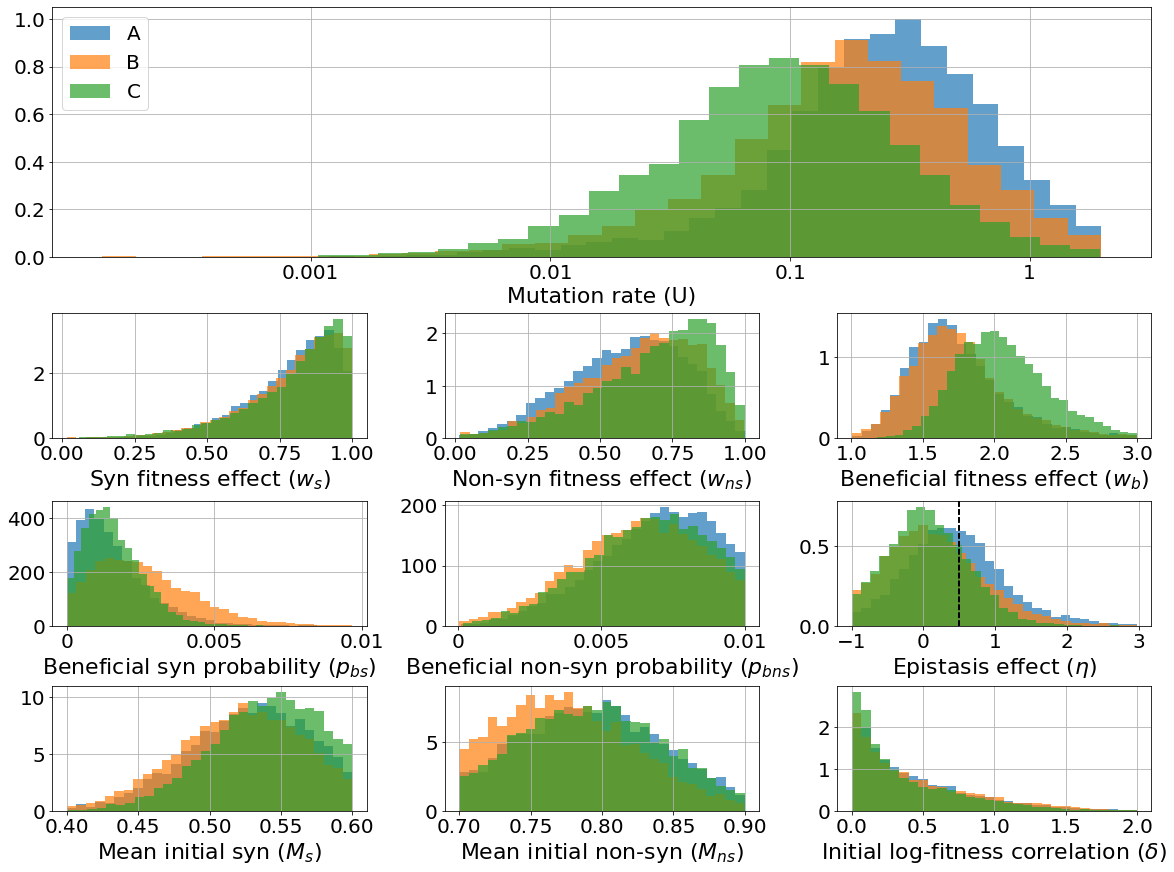

In [14]:
compare_posts_across_lines(inf_LR)

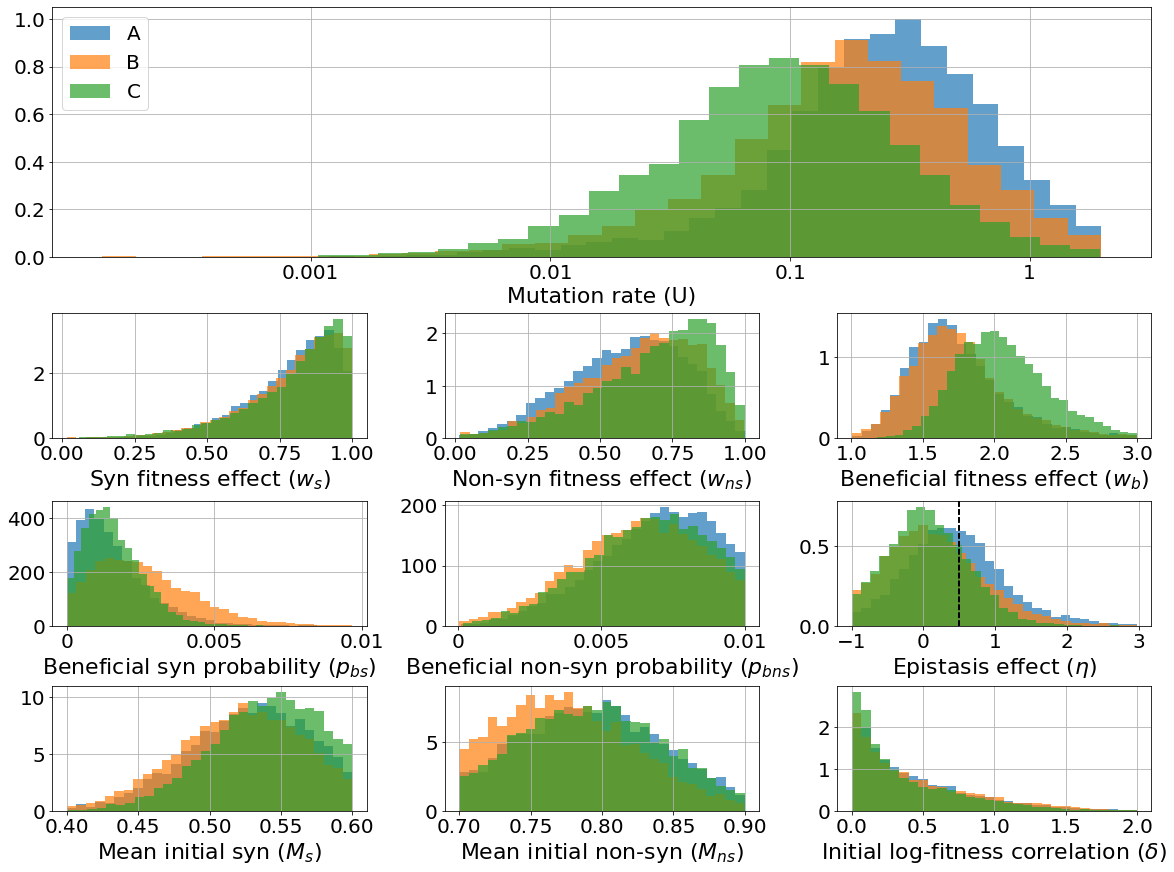

In [15]:
compare_posts_across_lines(inf_LR)

# L-LR Inference

In [16]:
inf_LLR = {}

## Figure 6

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.504000  -0.982887  1.345913   -0.054078  -0.651937   
1            w_syn  0.907500   0.651912  1.274160    0.999939   0.839644   
2        w_non_syn  0.713000   0.402286  0.944643    0.932608   0.649162   
3            w_ada  1.776500   1.469868  1.328891    2.129148   1.639390   
4        p_ada_syn  0.000705   0.000001  1.630636    0.002148   0.000250   
5    p_ada_non_syn  0.005660   0.003089  0.747188    0.009986   0.004944   
6           p0_syn  0.507000   0.418545  0.653163    0.591089   0.477850   
7       p0_non_syn  0.807000   0.714684  0.627838    0.890301   0.756584   
8        w_penalty  0.110000   0.000084  0.802930    1.427094   0.000084   
9  epistasis_boost -0.390500  -0.996503  1.144005    0.494406  -0.550511   

   hdi50_high     model  
0   -0.342246  ensemble  
1    0.953336  ensemble  
2    0.840177  ensemble  
3    1.852412  ensemble  
4    0.001058  ensemble  
5    0.

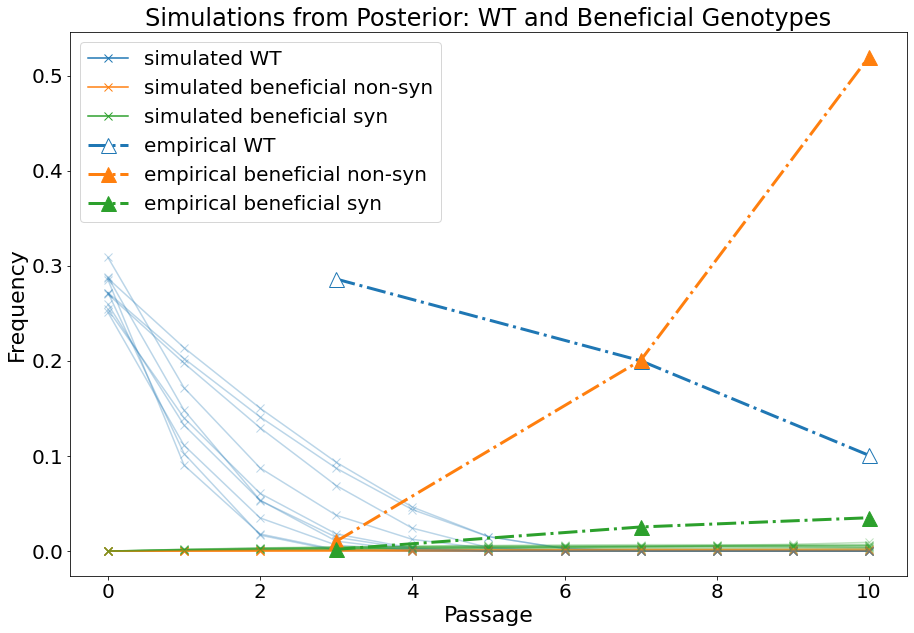

In [17]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=True, samples_per_model=1000, syn_prob=syn_prob)


In [18]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.773500  -1.161646  1.713651   -0.247528  -0.877236   
1            w_syn  0.873000   0.612703  1.174863    0.999972   0.799727   
2        w_non_syn  0.640000   0.237627  0.831868    0.875379   0.540839   
3            w_ada  1.798000   1.521726  1.516496    2.023084   1.704016   
4        p_ada_syn  0.001255   0.000001  1.474510    0.002549   0.000792   
5    p_ada_non_syn  0.007525   0.003395  0.770172    0.009995   0.005643   
6           p0_syn  0.499000   0.428137  0.649373    0.597154   0.477847   
7       p0_non_syn  0.789000   0.715500  0.631951    0.888225   0.764459   
8        w_penalty  0.068950   0.000034  1.231476    0.865155   0.000296   
9  epistasis_boost -0.334500  -0.997284  1.193719    0.429565  -0.513953   

   hdi50_high     model  
0   -0.569861  ensemble  
1    0.931439  ensemble  
2    0.770866  ensemble  
3    1.877735  ensemble  
4    0.001735  ensemble  
5    0.

In [19]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.959000  -1.348639  2.081958   -0.404371  -1.055018   
1            w_syn  0.906500   0.690479  1.335248    0.999862   0.865313   
2        w_non_syn  0.661000   0.324055  0.855953    0.933690   0.561369   
3            w_ada  1.995500   1.734059  1.383335    2.335662   1.895202   
4        p_ada_syn  0.000589   0.000001  1.785499    0.001750   0.000244   
5    p_ada_non_syn  0.006970   0.003095  0.764133    0.009917   0.005153   
6           p0_syn  0.501000   0.432214  0.650493    0.598761   0.477336   
7       p0_non_syn  0.797000   0.713612  0.620471    0.889272   0.764677   
8        w_penalty  0.024100   0.000035  1.461001    0.659558   0.000510   
9  epistasis_boost -0.391000  -0.998170  1.213986    0.376533  -0.732680   

   hdi50_high     model  
0   -0.747640  ensemble  
1    0.976910  ensemble  
2    0.779120  ensemble  
3    2.097611  ensemble  
4    0.000923  ensemble  
5    0.

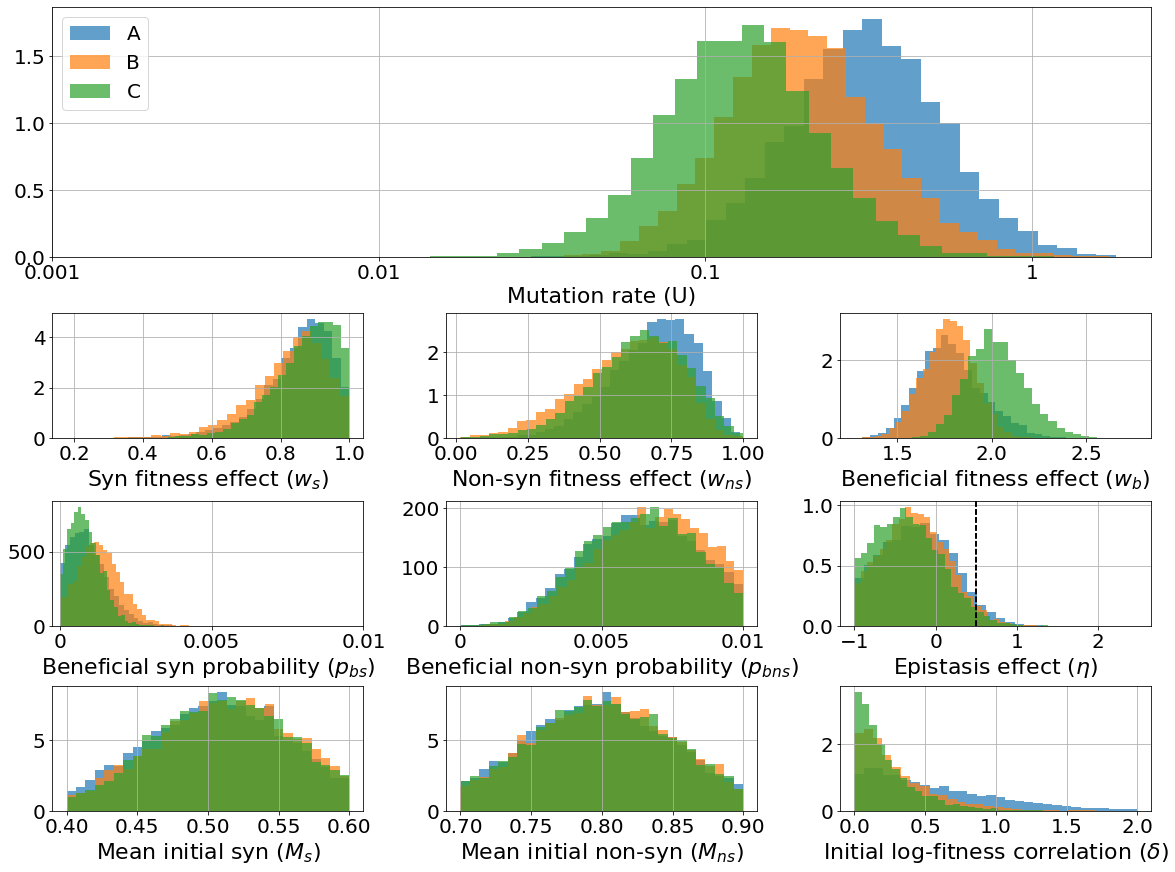

In [20]:
compare_posts_across_lines(inf_LLR)

# SR Inference

In [21]:
inf_SR = {}

In [22]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  \
0               mu -0.875000 -1.767305e+00  1.372021    0.145923   
1            w_syn  0.908000  4.517802e-01  0.957627    0.999997   
2        w_non_syn  0.836500  2.617987e-01  0.738597    0.984946   
3            w_ada  2.071000  1.326793e+00  0.717971    2.863893   
4        p_ada_syn  0.002030  1.884797e-07  0.859569    0.006173   
5    p_ada_non_syn  0.006360  2.686345e-03  0.717687    0.009982   
6           p0_syn  0.561000  4.624608e-01  0.760632    0.599983   
7       p0_non_syn  0.765000  7.032018e-01  0.640008    0.874588   
8        w_penalty  0.008955  9.014482e-07  1.068125    1.251389   
9  epistasis_boost  0.134000 -9.999903e-01  0.917187    1.259007   

      hdi50_low  hdi50_high     model  
0 -1.168865e+00   -0.470980  ensemble  
1  8.016759e-01    0.978476  ensemble  
2  6.184536e-01    0.902916  ensemble  
3  1.748178e+00    2.325632  ensemble  
4  1.017806e-03    0.003204  ensemble  
5  5.705236

In [23]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.80000  -1.927726  1.416464    0.202370  -1.131162   
1            w_syn  0.92650   0.457496  0.965277    0.999944   0.810520   
2        w_non_syn  0.81600   0.239760  0.718184    0.975034   0.602167   
3            w_ada  2.12900   1.277696  0.679756    2.895805   1.857406   
4        p_ada_syn  0.00224   0.000036  0.781571    0.006899   0.001541   
5    p_ada_non_syn  0.00826   0.002596  0.711731    0.010000   0.005593   
6           p0_syn  0.53900   0.452118  0.740804    0.599937   0.517495   
7       p0_non_syn  0.75900   0.700408  0.653347    0.865689   0.734577   
8        w_penalty  0.03000   0.000014  0.988161    1.396050   0.000014   
9  epistasis_boost  0.01619  -0.985810  0.892729    1.392294  -0.475056   

   hdi50_high     model  
0   -0.343593  ensemble  
1    0.985617  ensemble  
2    0.896247  ensemble  
3    2.472927  ensemble  
4    0.004045  ensemble  
5    0.008638  ens

In [24]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.94250  -1.801467  1.381255    0.198093  -1.098114   
1            w_syn  0.88600   0.431728  0.939444    0.998575   0.802677   
2        w_non_syn  0.77800   0.295706  0.747805    0.990641   0.636670   
3            w_ada  2.01000   1.356887  0.698848    2.902093   1.817862   
4        p_ada_syn  0.00245   0.000009  0.892877    0.005770   0.001016   
5    p_ada_non_syn  0.00776   0.002702  0.712551    0.009996   0.006100   
6           p0_syn  0.53700   0.446621  0.701888    0.599963   0.516888   
7       p0_non_syn  0.77500   0.701843  0.660487    0.868614   0.755209   
8        w_penalty  0.02990   0.000021  1.001900    1.406376   0.000489   
9  epistasis_boost  0.05835  -0.996249  0.947651    1.122222  -0.275374   

   hdi50_high     model  
0   -0.374807  ensemble  
1    0.986744  ensemble  
2    0.913208  ensemble  
3    2.409447  ensemble  
4    0.003116  ensemble  
5    0.009043  ens

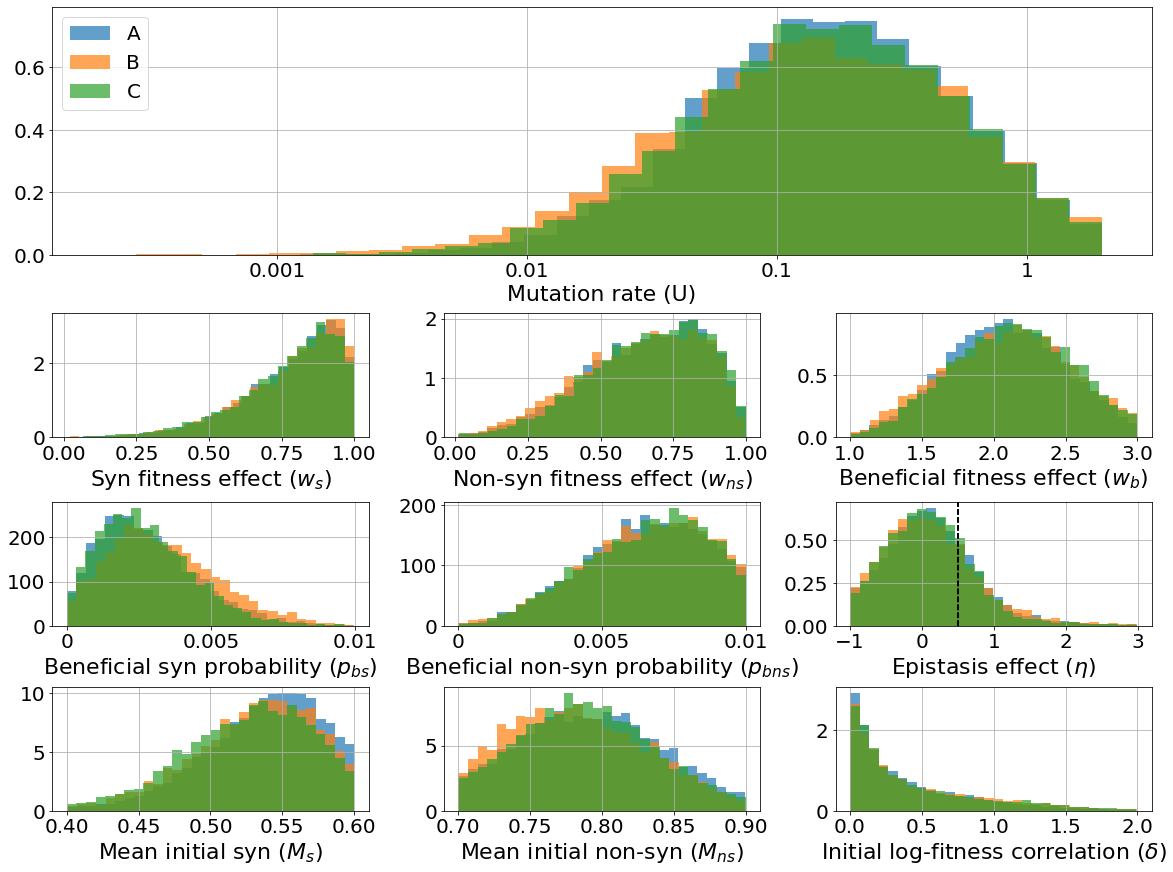

In [25]:
compare_posts_across_lines(inf_SR)

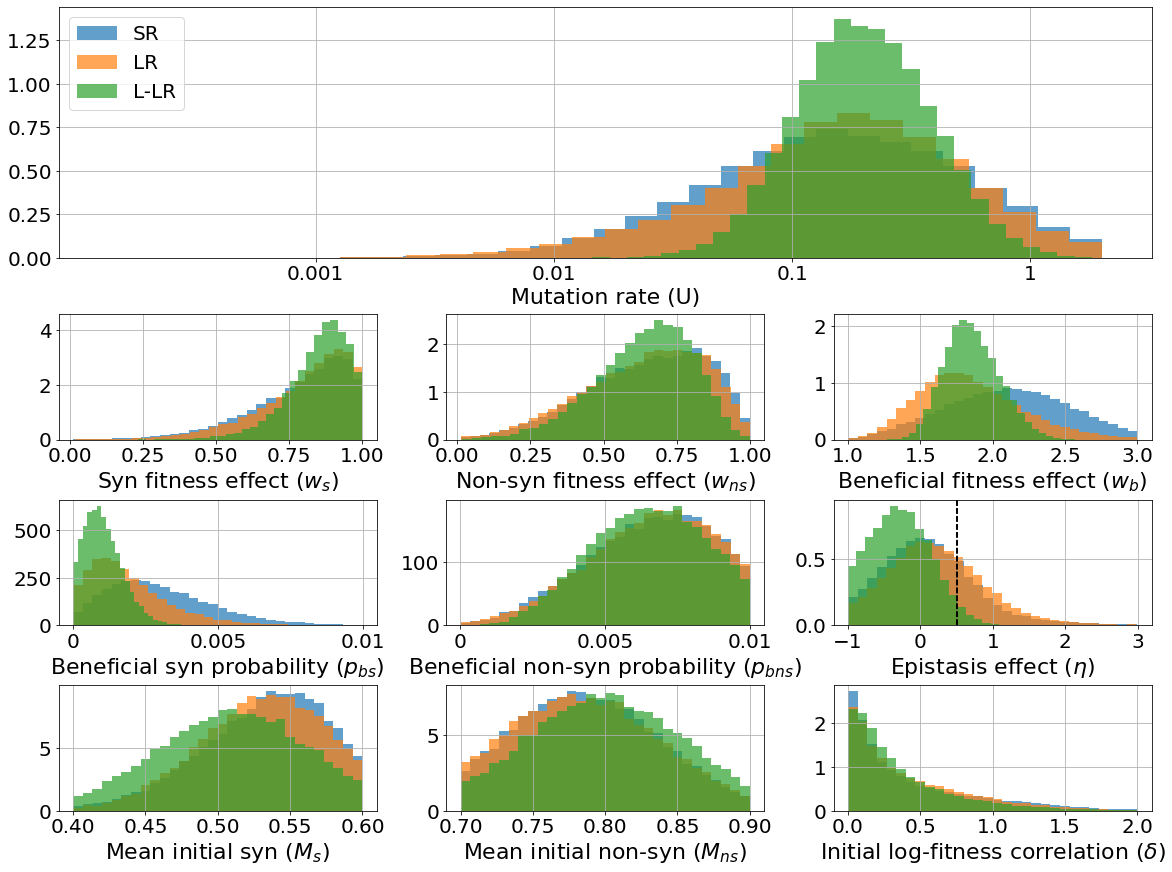

In [26]:
all_posts = {'SR': pd.concat([x[0] for x in inf_SR.values()]),
             'LR': pd.concat([x[0] for x in inf_LR.values()]),
             'L-LR': pd.concat([x[0] for x in inf_LLR.values()])}
compare_posts(all_posts)

## Fig 4A

This code block requires FITS posterior file (FITS_post.tsv) which can be download from [Zenodo](https://zenodo.org/record/7486851/files/FITS_post.tar.gz?download=1)


In [49]:
def plot_post_estimates(ax):
    fits_post = pd.read_table('FITS/FITS_post.tsv')
    sample_size = 10000
    bin_num = 30
    alpha = 0.6
    fits_post.log_U.sample(sample_size).hist(bins=bin_num, ax=ax, label='FITS', density=True, color=sns.color_palette()[7])
    all_posts['SR']['Mutation rate (U)'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='SR', 
                                                               density=True,ax=ax)
    all_posts['LR']['Mutation rate (U)'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='LR', 
                                                               density=True, ax=ax)
    all_posts['L-LR']['Mutation rate (U)'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='L-LR', 
                                                                 density=True, ax=ax)
    xticks = [-3,-2,-1, 0, 1]
    ax.set_xticks(xticks)
    ax.set_xticklabels([10**x for x in xticks])
    ax.set_yticks([0,0.5,1,1.5])
    ax.legend()
    ax.set_xlabel('Mutation rate (U)')

def compare_posts_for_paper(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1), legend_loc=(0.42,0.46)):
    mosaic = """
        AAA
        AAA
        BCD
        EFG
        """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'E', 
                          r'Beneficial fitness effect ($w_{b}$)': 'D', 
                          r'Epistasis effect ($\eta$)': 'G', 
                          r'Beneficial non-syn probability ($p_{bns}$)': 'F'}
    if not colors:
        colors = sns.color_palette(None)
    legend = True
    for col_name, ax_index in param_to_plot_dict.items():
        ax = ax_dict[ax_index]
        if 'Mutation' in col_name:
            col = 'err'
            plot_post_estimates(ax)
        else:
            col = 'rel_err'
            for i, (name, df) in enumerate(posts.items()):
                df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i], density=True)
                if 'probability' in col_name:
                    xticks = [0, 0.005, 0.01]
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticks)
                if 'stasis' in col_name:
                    ax.axvline(0.5, ls='--', color='k')    
            ax.set_xlabel(col_name)
            legend = False
    


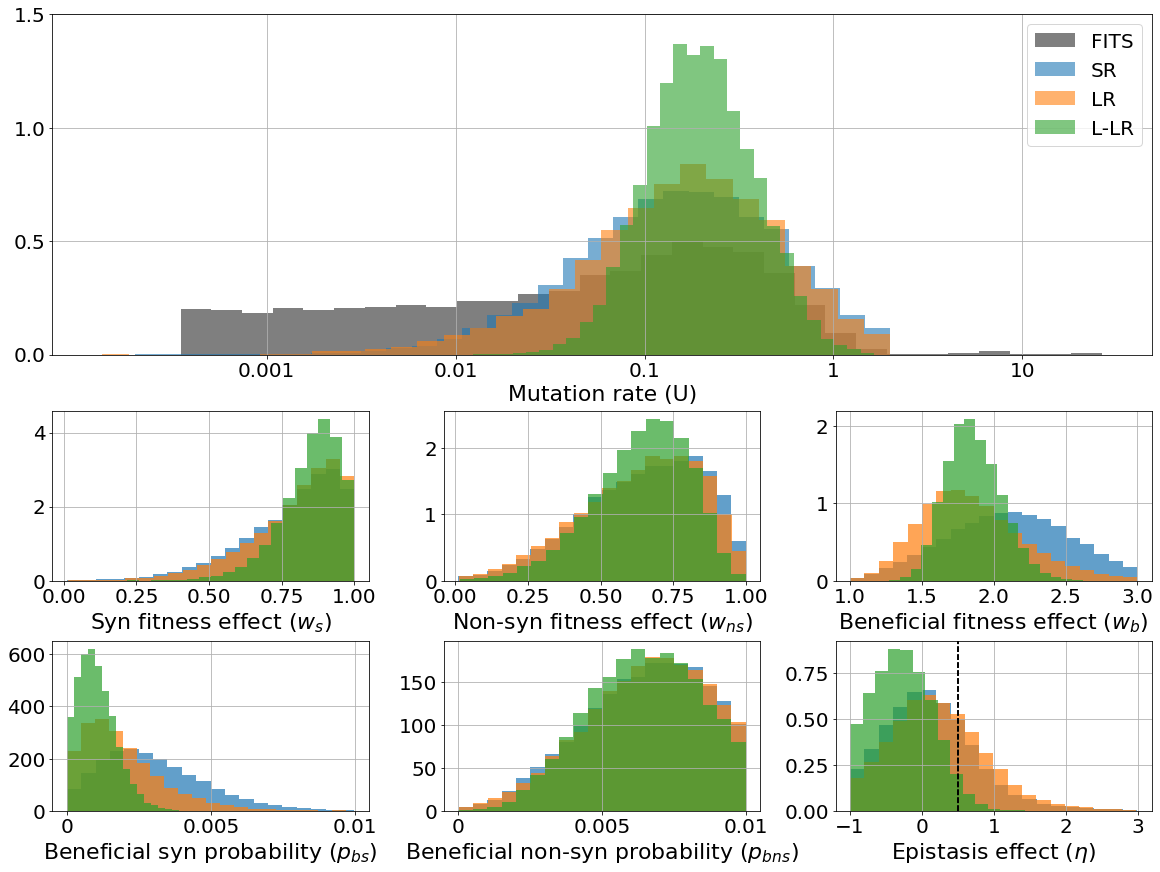

In [50]:
compare_posts_for_paper({'SR': all_posts['SR'], 'LR': all_posts['LR'], 'L-LR': all_posts['L-LR']})

## Table 1 + Table S2 data

In [29]:
all_posts_tmp = {k :v.rename(columns={v:k for k,v in rename_dict.items()}) for k,v in all_posts.items()}
stats = {k : calc_stats(v, None, prior) for k,v in all_posts_tmp.items()}
for k, v in stats.items():
    for param in v.param.unique():
        print(k)
        print(param)
        print(v[v.param==param][['hdi95_low', 'mode', 'hdi95_high']])

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


SR
mu
   hdi95_low  mode  hdi95_high
0  -1.825973 -0.88    0.197287
SR
w_ada
   hdi95_low  mode  hdi95_high
1   1.325949  2.13    2.897005
SR
w_syn
   hdi95_low   mode  hdi95_high
2   0.447763  0.906    0.999997
SR
w_non_syn
   hdi95_low   mode  hdi95_high
3   0.260723  0.817    0.982262
SR
p_ada_non_syn
   hdi95_low     mode  hdi95_high
4   0.002663  0.00776    0.009991
SR
p_ada_syn
   hdi95_low     mode  hdi95_high
5   0.000009  0.00224    0.006333
SR
p0_non_syn
   hdi95_low   mode  hdi95_high
6   0.702217  0.767     0.87058
SR
p0_syn
   hdi95_low   mode  hdi95_high
7   0.453467  0.539    0.599963
SR
w_penalty
      hdi95_low  mode  hdi95_high
8  9.014482e-07  0.03    1.359822
SR
epistasis_boost
   hdi95_low   mode  hdi95_high
9   -0.99999  0.178     1.25649
LR
mu
   hdi95_low   mode  hdi95_high
0  -1.844616 -0.763    0.183667
LR
w_ada
   hdi95_low  mode  hdi95_high
1   1.217687  1.77    2.590849
LR
w_syn
   hdi95_low   mode  hdi95_high
2   0.480793  0.916    0.999983
LR
w_non_syn
  

# Large Errors (10x loop errs)

In [30]:
large_errs_LLR = {}

In [31]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.909500  -1.443597  1.879392   -0.289951  -1.133578   
1            w_syn  0.849500   0.661630  1.298672    0.998401   0.796314   
2        w_non_syn  0.467500   0.112444  0.877167    0.712820   0.334722   
3            w_ada  1.826000   1.564682  1.354033    2.198581   1.731550   
4        p_ada_syn  0.000762   0.000009  1.831441    0.001687   0.000455   
5    p_ada_non_syn  0.008120   0.004158  0.861551    0.009998   0.006569   
6           p0_syn  0.529000   0.421389  0.641495    0.594691   0.472053   
7       p0_non_syn  0.789000   0.708746  0.648339    0.881124   0.753322   
8        w_penalty  0.410000   0.018874  0.837754    1.353127   0.191243   
9  epistasis_boost -0.583500  -0.999957  1.190530    0.437076  -0.778834   

   hdi50_high     model  
0   -0.734522  ensemble  
1    0.910789  ensemble  
2    0.542208  ensemble  
3    1.940530  ensemble  
4    0.001084  ensemble  
5    0.

In [32]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.393000  -0.813954  1.146361    0.052641  -0.519733   
1            w_syn  0.658000   0.494486  1.177478    0.873667   0.629241   
2        w_non_syn  0.281500   0.053217  1.073254    0.491636   0.194742   
3            w_ada  1.763000   1.543360  1.399075    2.115473   1.692544   
4        p_ada_syn  0.000592   0.000002  1.835744    0.001659   0.000281   
5    p_ada_non_syn  0.002085   0.000570  1.153456    0.004655   0.001604   
6           p0_syn  0.501000   0.409019  0.642265    0.580846   0.456349   
7       p0_non_syn  0.811000   0.703119  0.622197    0.878478   0.762304   
8        w_penalty  1.875500   0.885962  0.945412    1.999983   1.625168   
9  epistasis_boost -0.332500  -0.958522  1.159487    0.598335  -0.398249   

   hdi50_high     model  
0   -0.226959  ensemble  
1    0.761939  ensemble  
2    0.355476  ensemble  
3    1.897156  ensemble  
4    0.000931  ensemble  
5    0.

In [33]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.717500  -1.310989  1.497073   -0.082393  -0.889313   
1            w_syn  0.865000   0.701707  1.381486    0.992350   0.814466   
2        w_non_syn  0.430000   0.152026  0.987012    0.657191   0.342031   
3            w_ada  1.875500   1.606554  1.313355    2.269441   1.815724   
4        p_ada_syn  0.000779   0.000001  1.811397    0.001695   0.000336   
5    p_ada_non_syn  0.004460   0.002075  0.848618    0.008340   0.003548   
6           p0_syn  0.491000   0.400863  0.614117    0.575768   0.455278   
7       p0_non_syn  0.795000   0.708820  0.624871    0.884566   0.752992   
8        w_penalty  1.714500   0.660923  0.799443    1.999772   1.421502   
9  epistasis_boost -0.538000  -0.996409  1.206645    0.378891  -0.698536   

   hdi50_high     model  
0   -0.493696  ensemble  
1    0.915657  ensemble  
2    0.520423  ensemble  
3    2.039297  ensemble  
4    0.001000  ensemble  
5    0.

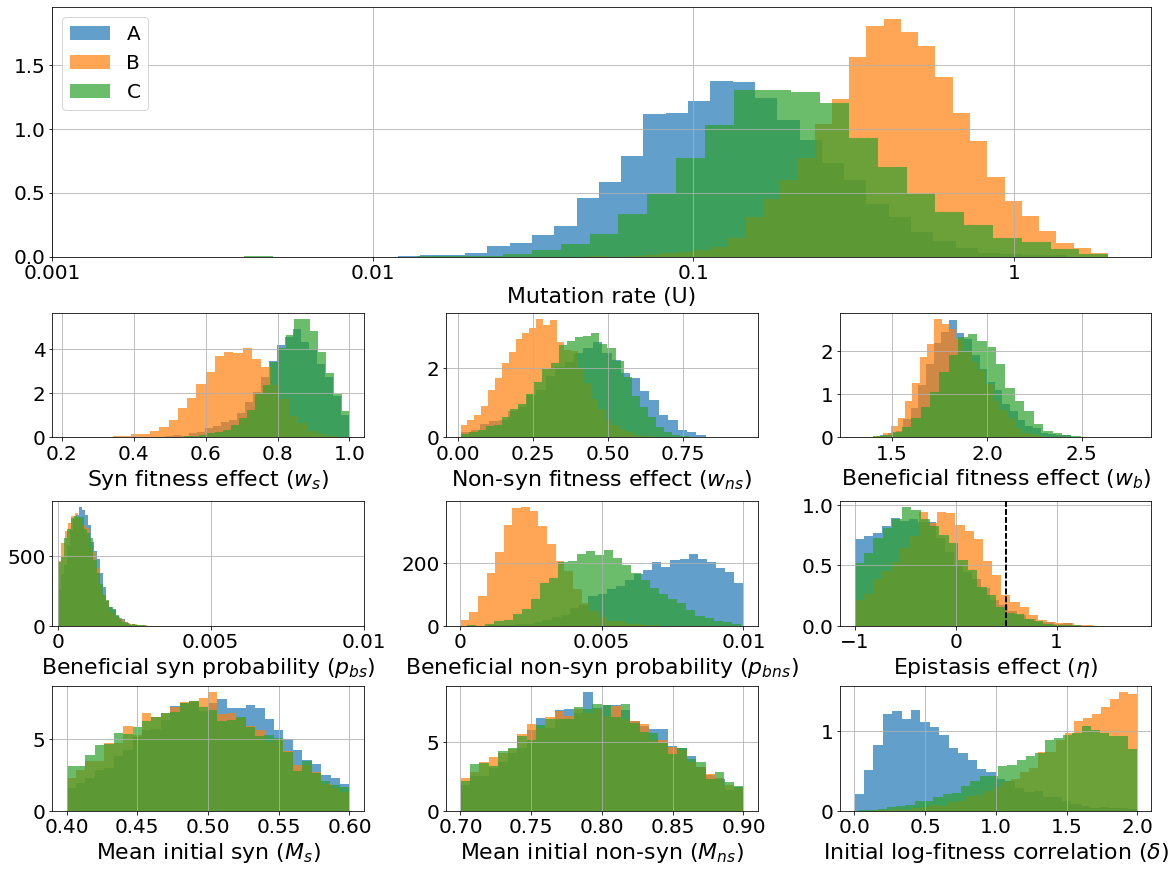

In [34]:
compare_posts_across_lines(large_errs_LLR)

## Fig 4B + S?

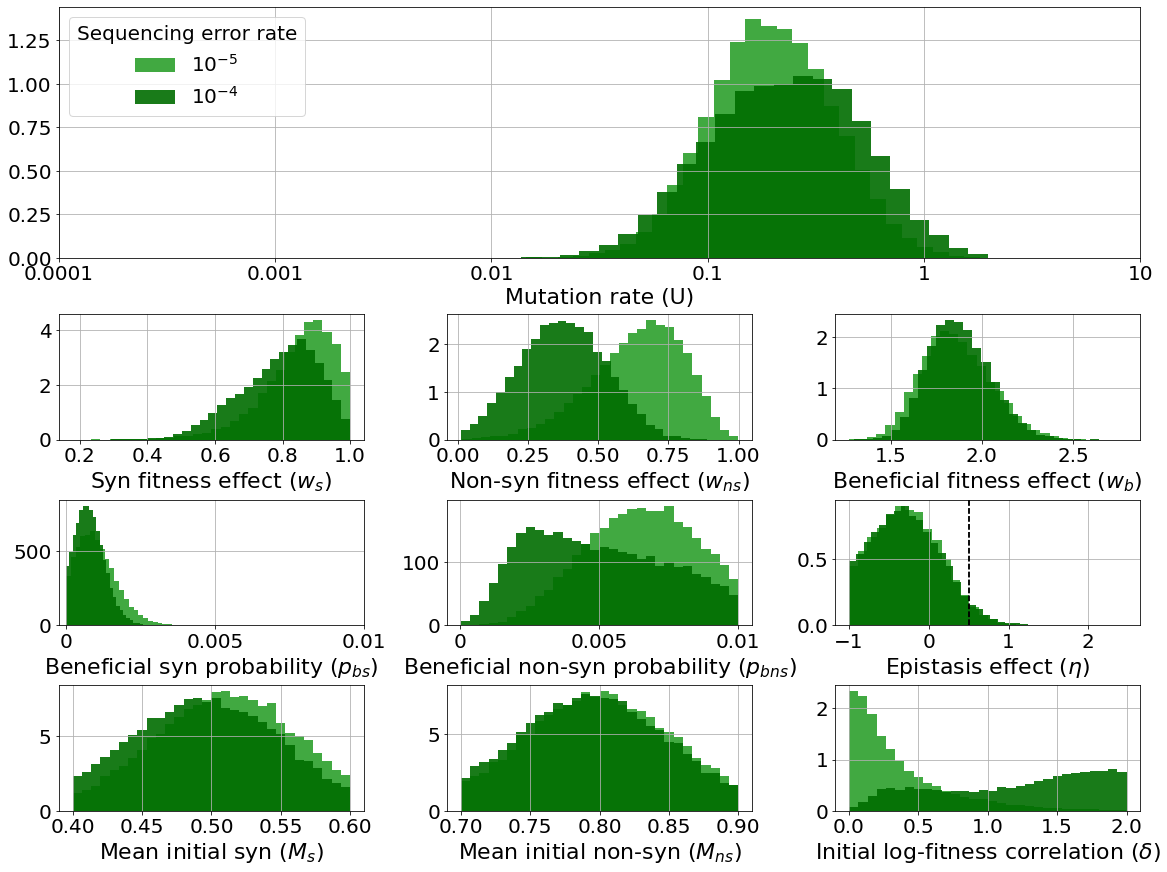

In [35]:
man_errs = {r'$10^{-5}$': pd.concat([x[0] for x in inf_LLR.values()]),
            r'$10^{-4}$': pd.concat([x[0] for x in large_errs_LLR.values()])}
not_C2 = [max(x-0.2,0) for x in sns.color_palette()[2]]
compare_posts(man_errs, mu_xticks=(-4,2), legend_title='Sequencing error rate',
                             colors=['C2', not_C2], alpha=0.9)

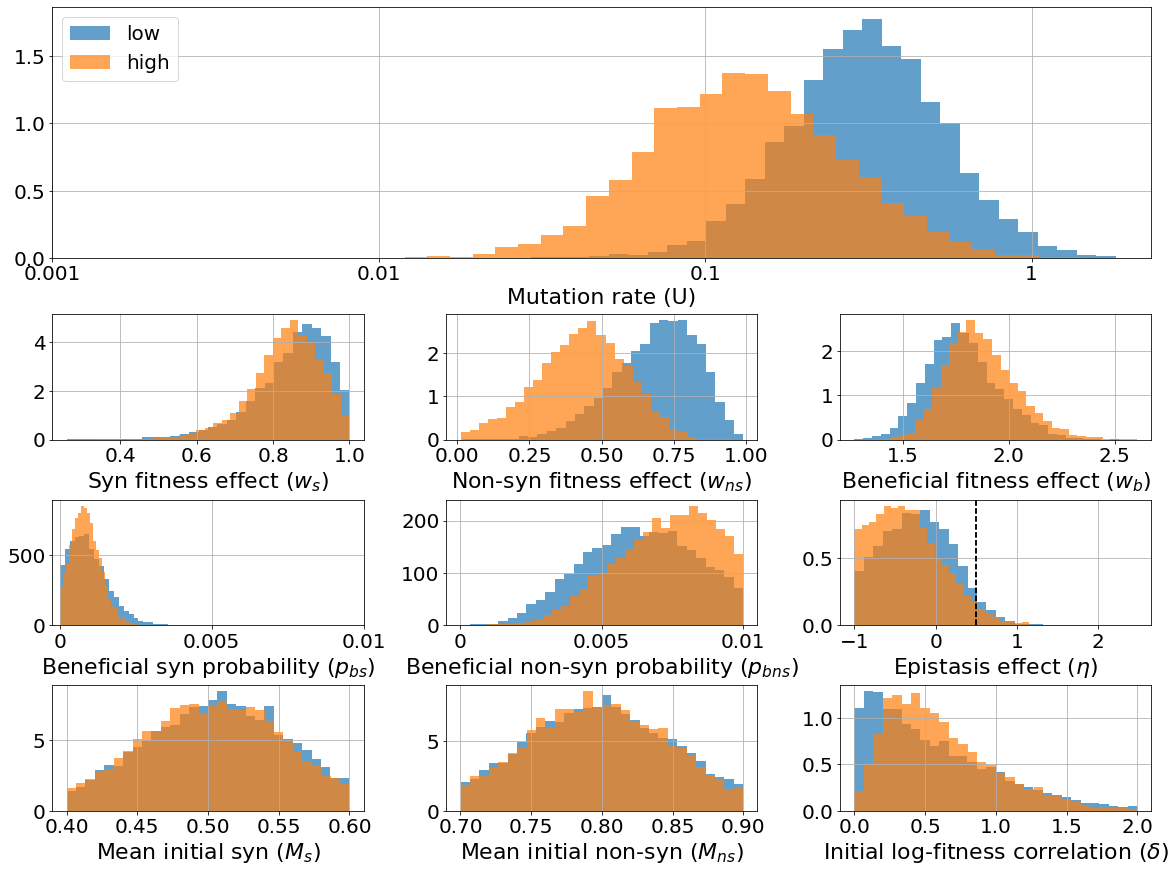

In [36]:
replica = 'A'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

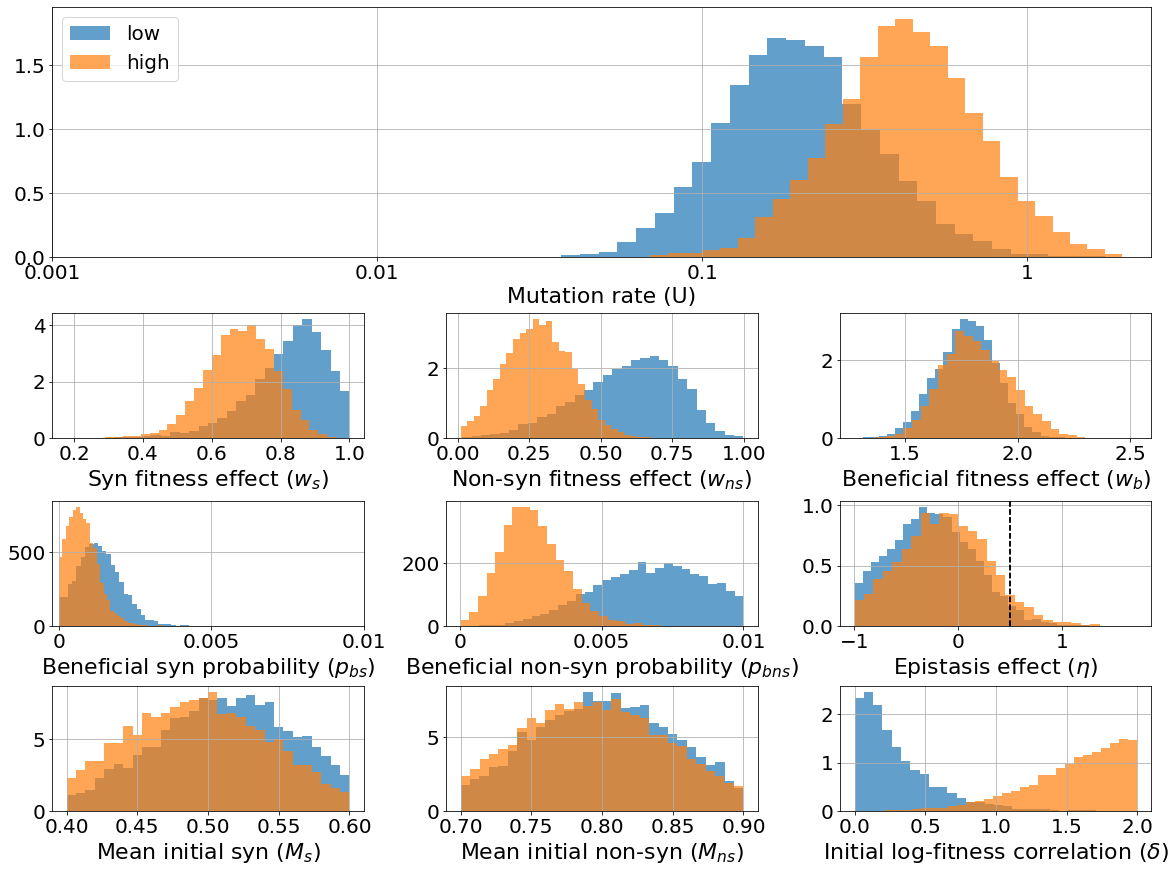

In [37]:
replica = 'B'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

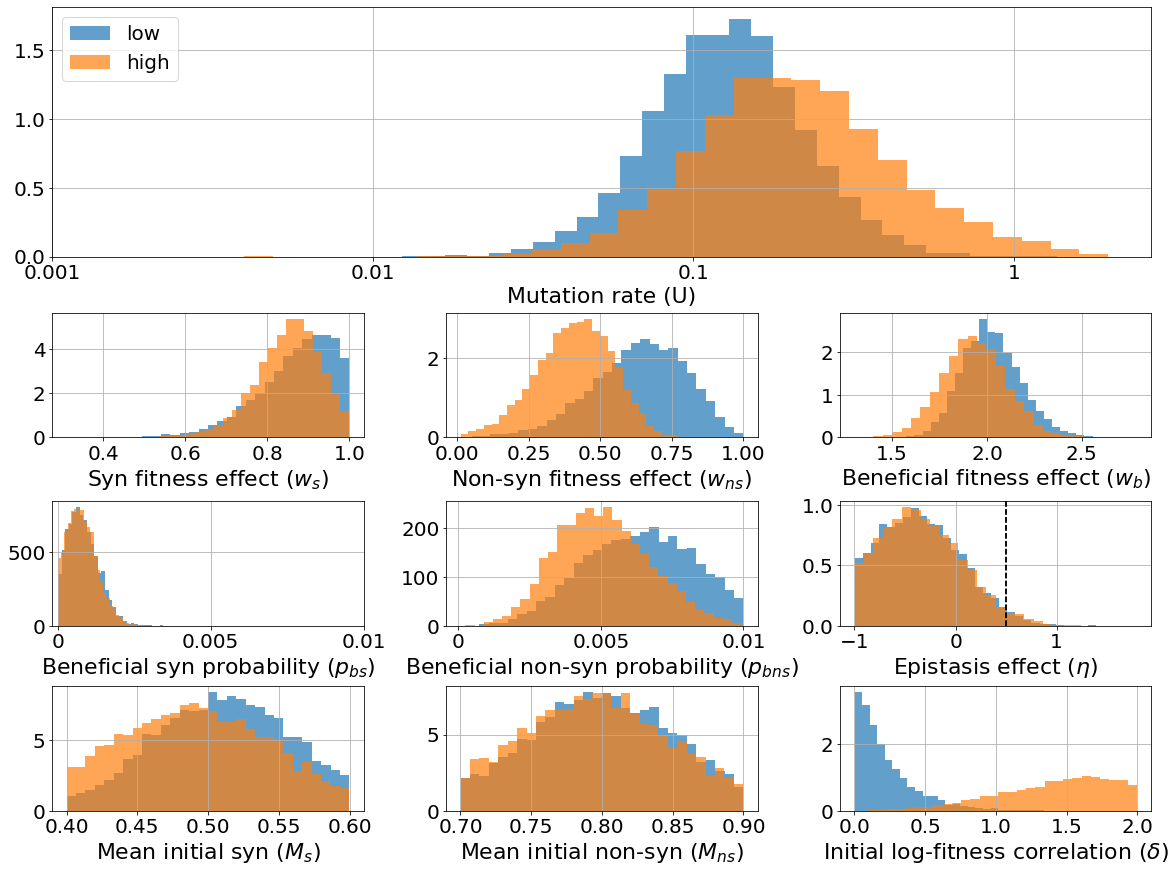

In [38]:
replica = 'C'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

In [39]:
large_errs_LR = {}

In [40]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -3.14300  -3.894971  6.397612   -2.248858  -3.457495   
1            w_syn  0.75850   0.456602  1.015276    0.955524   0.715205   
2        w_non_syn  0.28800   0.014770  0.727568    0.712735   0.172711   
3            w_ada  2.77100   2.341049  1.254607    2.999912   2.646278   
4        p_ada_syn  0.00224   0.000235  0.931584    0.005829   0.001755   
5    p_ada_non_syn  0.00747   0.003065  0.762404    0.009976   0.005491   
6           p0_syn  0.54300   0.455488  0.716596    0.599978   0.506018   
7       p0_non_syn  0.80900   0.732005  0.645183    0.899102   0.788518   
8        w_penalty  0.25800   0.028142  1.170400    0.999361   0.140025   
9  epistasis_boost  1.63600   0.703947  0.994594    2.738475   1.305976   

   hdi50_high     model  
0   -2.881202  ensemble  
1    0.879410  ensemble  
2    0.464548  ensemble  
3    2.912828  ensemble  
4    0.003687  ensemble  
5    0.008138  ens

In [41]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -1.00650  -1.709310  1.881965   -0.271104  -1.224522   
1            w_syn  0.84200   0.529999  1.156886    0.952456   0.773454   
2        w_non_syn  0.34500   0.033116  0.882658    0.595575   0.184923   
3            w_ada  1.86750   1.393607  0.950372    2.507322   1.741136   
4        p_ada_syn  0.00362   0.000704  0.912519    0.006497   0.002266   
5    p_ada_non_syn  0.00715   0.002750  0.733248    0.009995   0.005670   
6           p0_syn  0.45900   0.402490  0.643614    0.573907   0.453335   
7       p0_non_syn  0.78500   0.709449  0.641869    0.884330   0.760946   
8        w_penalty  0.57450   0.263019  0.673921    1.865064   0.436525   
9  epistasis_boost  0.98600   0.566659  1.544967    1.741683   0.872268   

   hdi50_high     model  
0   -0.733491  ensemble  
1    0.901814  ensemble  
2    0.404679  ensemble  
3    2.120329  ensemble  
4    0.004326  ensemble  
5    0.008594  ens

In [42]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu  0.03875  -0.495517  0.757212    0.299918  -0.200915   
1            w_syn  0.59550   0.348012  1.002299    0.823087   0.529311   
2        w_non_syn  0.15600   0.010115  1.171840    0.380515   0.091725   
3            w_ada  1.34700   1.066488  1.293301    1.735333   1.251942   
4        p_ada_syn  0.00264   0.000193  0.836917    0.006521   0.001933   
5    p_ada_non_syn  0.00856   0.003471  0.792164    0.010000   0.006644   
6           p0_syn  0.47500   0.400355  0.645155    0.569498   0.431440   
7       p0_non_syn  0.79500   0.714706  0.620138    0.890552   0.765590   
8        w_penalty  1.59100   0.652094  0.778879    1.999974   1.433491   
9  epistasis_boost -0.06880  -0.999099  0.890537    1.312184  -0.547362   

   hdi50_high     model  
0    0.102521  ensemble  
1    0.708224  ensemble  
2    0.230941  ensemble  
3    1.484338  ensemble  
4    0.004193  ensemble  
5    0.009301  ens

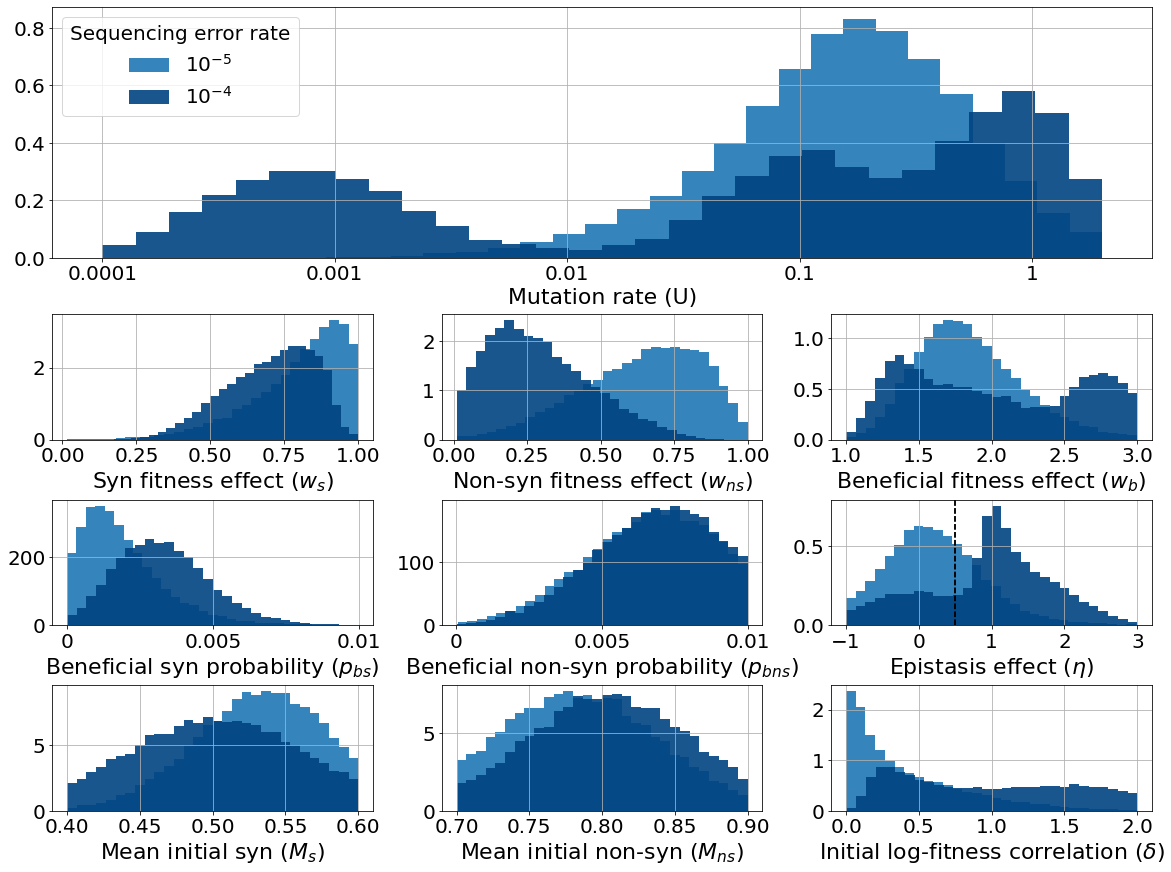

In [43]:
LR_errs = {r'$10^{-5}$': pd.concat([x[0] for x in inf_LR.values()]),
            r'$10^{-4}$': pd.concat([x[0] for x in large_errs_LR.values()])}
not_C0 = [max(x-0.2,0) for x in sns.color_palette()[0]]
compare_posts(LR_errs, mu_xticks=(-4,1), legend_title='Sequencing error rate',
                             colors=['C0', not_C0], alpha=0.9)

In [44]:
large_errs_SR = {}

In [45]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'SR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -3.15250  -3.999794  5.911048   -1.818117  -3.658348   
1            w_syn  0.88200   0.500206  1.014219    0.992675   0.762094   
2        w_non_syn  0.41550   0.016344  0.696545    0.744413   0.233587   
3            w_ada  2.41000   1.487922  0.686022    2.998530   1.930561   
4        p_ada_syn  0.00335   0.000005  0.694013    0.008033   0.001219   
5    p_ada_non_syn  0.00636   0.001838  0.659711    0.009990   0.004276   
6           p0_syn  0.55500   0.461230  0.759694    0.599971   0.519404   
7       p0_non_syn  0.83300   0.738238  0.660754    0.899954   0.805915   
8        w_penalty  0.22500   0.057452  1.128722    1.093774   0.137192   
9  epistasis_boost  2.22200   1.143365  0.998548    2.975433   1.716277   

   hdi50_high     model  
0   -2.784348  ensemble  
1    0.928167  ensemble  
2    0.555766  ensemble  
3    2.615376  ensemble  
4    0.004264  ensemble  
5    0.007660  ens

In [46]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'SR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -1.18300  -2.292192  1.967287   -0.064037  -1.527200   
1            w_syn  0.87050   0.493398  1.116774    0.953448   0.776484   
2        w_non_syn  0.35900   0.036507  0.824507    0.631571   0.191057   
3            w_ada  2.67450   1.448827  0.681137    2.999489   2.177715   
4        p_ada_syn  0.00394   0.000786  0.775677    0.007817   0.002649   
5    p_ada_non_syn  0.00686   0.002795  0.756861    0.009965   0.005547   
6           p0_syn  0.49500   0.402167  0.626691    0.572786   0.451283   
7       p0_non_syn  0.80900   0.716106  0.624285    0.891063   0.767903   
8        w_penalty  0.68100   0.241462  0.657416    1.846315   0.518051   
9  epistasis_boost  0.80150  -0.156878  1.001453    2.059792   0.459329   

   hdi50_high     model  
0   -0.770387  ensemble  
1    0.909318  ensemble  
2    0.440229  ensemble  
3    2.821482  ensemble  
4    0.005252  ensemble  
5    0.008264  ens

In [47]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'SR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.12900  -0.756527  0.790006    0.287404  -0.420596   
1            w_syn  0.50850   0.283088  0.892309    0.831915   0.434944   
2        w_non_syn  0.12500   0.010015  1.166684    0.408006   0.044193   
3            w_ada  2.47400   1.785120  0.831738    2.999023   2.288026   
4        p_ada_syn  0.00386   0.000831  0.841406    0.007158   0.002694   
5    p_ada_non_syn  0.00827   0.003375  0.786838    0.009998   0.006382   
6           p0_syn  0.50700   0.409118  0.605116    0.587629   0.458570   
7       p0_non_syn  0.78900   0.707899  0.604360    0.887584   0.748700   
8        w_penalty  1.11100   0.461603  0.686883    1.995545   0.865837   
9  epistasis_boost -0.24350  -0.997624  1.166799    0.481571  -0.776107   

   hdi50_high     model  
0   -0.013608  ensemble  
1    0.653907  ensemble  
2    0.178907  ensemble  
3    2.772418  ensemble  
4    0.004905  ensemble  
5    0.008980  ens

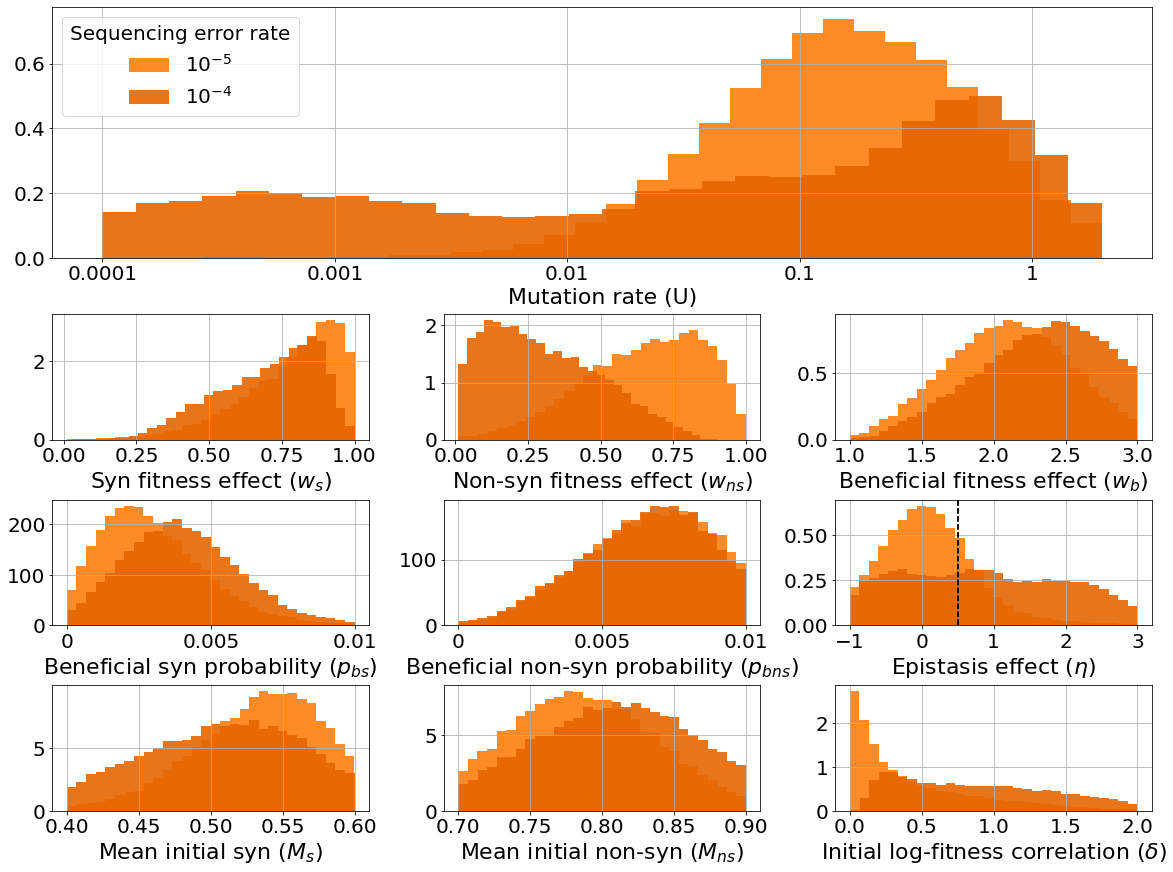

In [48]:
SR_errs = {r'$10^{-5}$': pd.concat([x[0] for x in inf_SR.values()]),
            r'$10^{-4}$': pd.concat([x[0] for x in large_errs_SR.values()])}
not_C1 = [max(x-0.1,0) for x in sns.color_palette()[1]]
compare_posts(SR_errs, mu_xticks=(-4,1), legend_title='Sequencing error rate',
                             colors=['C1', not_C1], alpha=0.9)